# Assignment 5

Deadline: 11.06.2025 12:00 CEST

## Task

Develop an investment strategy for the Swiss equity market, backtest it using the provided datasets (`market_data.parquet`, `jkp_data.parquet`, `spi_index.csv`) and analyze its performance by benchmarking it against the SPI index. Work with the existing code infrastructure (`qpmwp-course`) and extend it by implementing any additional components needed for the strategy. Write a report that presents your methodology and the results.

### Coding (15 points)

- Selection:
  Implement selection item builder functions (via `SelectionItemBuilder`) to filter stocks based on specific criteria (e.g., exclude low-quality or high-volatility stocks).

- Optimization Data & Constraints:
  Implement functions to prepare optimization data (via `OptimizationItemBuilder`), including any econometric or machine learning-based predictions. These functions should also define optimization constraints (e.g., stock, sector, or factor exposure limits).

- Optimization Model:
  If you choose to create a custom optimization model, develop a class inheriting from Optimization (similar to `MeanVariance`, `LeastSquares`, or `BlackLitterman`). Your class should include methods set_objective and solve for defining the objective function and solving the optimization problem.

- Machine Learning Prediction:
  Integrate a machine learning model to estimate inputs for the optimization, such as expected returns or risk. This could include regression, classification, or learning-to-rank models. I suggest you to use the provided jkp_data as features, but you may also create your own (e.g., technical indicators computed on the return or price series).

- Simulation:
  Backtest the strategy and simulate portfolio returns. Account for fixed costs (1% per annum) and variable (transaction) costs (0.2% per rebalancing).


### Report (15 points):

Generate an HTML report with the following sections:

- High-level strategy overview: Describe the investment strategy you developed.

- Detailed explanation of the backtesting steps: Offer a more comprehensive breakdown of the backtesting process, including a description of the models implemented (e.g., details of the machine learning method used).

- Backtesting results:
    
    - Charts: Include visual representations (e.g., cumulative performance charts, rolling 3-year returns, etc.).
    - Descriptive statistics: Present key statistics such as mean, standard deviation, drawdown, turnover, and Sharpe ratio (or any other relevant metric) for the full backtest period as well as for subperiods (e.g., the last 5 years, or during bull vs. bear market phases).
    - Compare your strategy against the SPI index.


In [1]:
# Standard library imports
import os, sys

project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
src_path     = os.path.join(project_root, "src")


# insert src/ on sys.path so your helpers resolve
if src_path not in sys.path:
    sys.path.insert(0, src_path)



if project_root not in sys.path:
    sys.path.insert(0, project_root)



# Third party imports
import numpy as np
import pandas as pd

# Local imports from src folder
from helper_functions import load_data_spi, load_pickle
from estimation.covariance import Covariance, CovarianceSpecification
from estimation.expected_return import ExpectedReturn, ExpectedReturnSpecification
from optimization.optimization import Optimization, Objective, MeanVariance
from optimization.optimization_data import OptimizationData
from optimization.constraints import Constraints
from backtesting.backtest_item_builder_classes import (
    SelectionItemBuilder,
    OptimizationItemBuilder,
)
from backtesting.backtest_item_builder_functions import (
    bibfn_selection_min_volume,
    bibfn_selection_gaps,
    bibfn_return_series,
    bibfn_budget_constraint,
    bibfn_box_constraints,
    bibfn_size_dependent_upper_bounds,
    bibfn_turnover_constraint,
)
from backtesting.backtest_data import BacktestData
from backtesting.backtest_service import BacktestService
from backtesting.backtest import Backtest


In [2]:
# Load data
path_to_data = '/Users/elenetsaouse/qpmwp-course/qpmwp-course/data'  

# Load market and jkp data from parquet files
market_data = pd.read_parquet(f'/Users/elenetsaouse/Downloads/market_data.parquet')
jkp_data = pd.read_parquet('/Users/elenetsaouse/Downloads/jkp_data.parquet')

# Instantiate the BacktestData class
# and set the market data and jkp data as attributes
data = BacktestData()
data.market_data = market_data
data.jkp_data = jkp_data
data.bm_series = load_data_spi(path='../data/')

## Test Part (Not finished yet)

Map Characteristic Dates to Next Trading Date- Important to avoid look ahead bias

In [3]:
# Get all unique dates from both datasets
market_data_dates = data.market_data.index.get_level_values('date').unique().sort_values()
jkp_data_dates = data.jkp_data.index.get_level_values('date').unique().sort_values()

# Map each characteristic date to the next available market trading date (T⁺¹)
dates_map = {}
for date in jkp_data_dates:
    future_dates = market_data_dates[market_data_dates > date]
    if not future_dates.empty:
        dates_map[date] = future_dates.min()

# Reindex characteristics so that each feature is aligned with next trading date
features = data.jkp_data.reset_index()
features['date'] = features['date'].map(dates_map)
features = features.dropna(subset=['date'])  # Drop rows without a matching future date
features = features.set_index(['date', 'id']).sort_index()


In [4]:
features

niq_su  ret_6_1  ret_12_1  saleq_su  tax_gr1a  ni_inc8q  \
date       id                                                             
1986-01-01 107     NaN      NaN       NaN       NaN       NaN       NaN   
           107     NaN      NaN       NaN       NaN       NaN       NaN   
           11      NaN      NaN       NaN       NaN       NaN       NaN   
           119     NaN      NaN       NaN       NaN       NaN       NaN   
           12      NaN      NaN       NaN       NaN       NaN       NaN   
...                ...      ...       ...       ...       ...       ...   
2024-04-01 NaN     NaN      NaN       NaN       NaN       NaN       NaN   
           NaN     NaN      NaN       NaN       NaN       NaN       NaN   
           NaN     NaN      NaN       NaN       NaN       NaN       NaN   
           NaN     NaN      NaN       NaN       NaN       NaN       NaN   
           NaN     NaN      NaN       NaN       NaN       NaN       NaN   

                prc_highprc_252d  resff3_6_1  resff3_12_1  be_me  ...  \
date       id                                                     ...   
1986-01-01 107               NaN         NaN          NaN    NaN  ...   
           107               NaN         NaN          NaN    NaN  ...   
           11                NaN         NaN          NaN    NaN  ...   
           119               NaN         NaN          NaN    NaN  ...   
           12                NaN         NaN          NaN    NaN  ...   
...                          ...         ...          ...    ...  ...   
2024-04-01 NaN               NaN         NaN          NaN    NaN  ...   
           NaN               NaN         NaN          NaN    NaN  ...   
           NaN               NaN         NaN          NaN    NaN  ...   
           NaN               NaN         NaN          NaN    NaN  ...   
           NaN               NaN         NaN          NaN    NaN  ...   

                rmax5_rvol_21d  ni_be  ocf_at  ocf_at_chg1  mispricing_perf  \
date       id                                                                 
1986-01-01 107             NaN    NaN     NaN          NaN              NaN   
           107             NaN    NaN     NaN          NaN              NaN   
           11              NaN    NaN     NaN          NaN              NaN   
           119             NaN    NaN     NaN          NaN              NaN   
           12              NaN    NaN     NaN          NaN              NaN   
...                        ...    ...     ...          ...              ...   
2024-04-01 NaN             NaN    NaN     NaN          NaN              NaN   
           NaN             NaN    NaN     NaN          NaN              NaN   
           NaN             NaN    NaN     NaN          NaN              NaN   
           NaN             NaN    NaN     NaN          NaN              NaN   
           NaN             NaN    NaN     NaN          NaN              NaN   

                mispricing_mgmt  qmj  qmj_prof  qmj_growth  qmj_safety  
date       id                                                           
1986-01-01 107              NaN  NaN       NaN         NaN         NaN  
           107              NaN  NaN       NaN         NaN         NaN  
           11               NaN  NaN       NaN         NaN         NaN  
           119              NaN  NaN       NaN         NaN         NaN  
           12               NaN  NaN       NaN         NaN         NaN  
...                         ...  ...       ...         ...         ...  
2024-04-01 NaN              NaN  NaN       NaN         NaN         NaN  
           NaN              NaN  NaN       NaN         NaN         NaN  
           NaN              NaN  NaN       NaN         NaN         NaN  
           NaN              NaN  NaN       NaN         NaN         NaN  
           NaN              NaN  NaN       NaN         NaN         NaN  

[130578 rows x 153 columns]

In [5]:
train_dates = features.index.get_level_values('date').unique().sort_values()
train_dates = train_dates[train_dates > market_data_dates[0]]
rebdates = train_dates[train_dates >= '2015-01-01'].strftime('%Y-%m-%d').tolist()
rebdates = rebdates[0:-1]
rebdates

['2015-01-01',
 '2015-02-02',
 '2015-03-02',
 '2015-04-01',
 '2015-05-01',
 '2015-06-01',
 '2015-07-01',
 '2015-08-03',
 '2015-09-01',
 '2015-10-01',
 '2015-11-02',
 '2015-12-01',
 '2016-01-01',
 '2016-02-01',
 '2016-03-01',
 '2016-04-01',
 '2016-05-02',
 '2016-06-01',
 '2016-07-01',
 '2016-08-01',
 '2016-09-01',
 '2016-10-03',
 '2016-11-01',
 '2016-12-01',
 '2017-01-02',
 '2017-02-01',
 '2017-03-01',
 '2017-04-03',
 '2017-05-01',
 '2017-06-01',
 '2017-07-03',
 '2017-08-01',
 '2017-09-01',
 '2017-10-02',
 '2017-11-01',
 '2017-12-01',
 '2018-01-01',
 '2018-02-01',
 '2018-03-01',
 '2018-04-02',
 '2018-05-01',
 '2018-06-01',
 '2018-07-02',
 '2018-08-01',
 '2018-09-03',
 '2018-10-01',
 '2018-11-01',
 '2018-12-03',
 '2019-01-01',
 '2019-02-01',
 '2019-03-01',
 '2019-04-01',
 '2019-05-01',
 '2019-06-03',
 '2019-07-01',
 '2019-08-01',
 '2019-09-02',
 '2019-10-01',
 '2019-11-01',
 '2019-12-02',
 '2020-01-01',
 '2020-02-03',
 '2020-03-02',
 '2020-04-01',
 '2020-05-01',
 '2020-06-01',
 '2020-07-

In [6]:
# Define the selection item builders.
selection_item_builders = {
    'gaps': SelectionItemBuilder(
        bibfn = bibfn_selection_gaps,
        width = 252*3,
        n_days = 10,
    ),
    'min_volume': SelectionItemBuilder(
        bibfn = bibfn_selection_min_volume,
        width = 252,
        min_volume = 500_000,
        agg_fn = np.median,
    ),
}

# Define the optimization item builders.
optimization_item_builders = {
    'return_series': OptimizationItemBuilder(
        bibfn = bibfn_return_series,
        width = 252*3,
        fill_value = 0,
    ),
    'budget_constraint': OptimizationItemBuilder(
        bibfn = bibfn_budget_constraint,
        budget = 1,
    ),
    'box_constraints': OptimizationItemBuilder(
        bibfn = bibfn_box_constraints,
        upper = 0.1,
    ),
    'size_dep_upper_bounds': OptimizationItemBuilder(
        bibfn = bibfn_size_dependent_upper_bounds,
        small_cap = {'threshold': 300_000_000, 'upper': 0.02},
        mid_cap = {'threshold': 1_000_000_000, 'upper': 0.05},
        large_cap = {'threshold': 10_000_000_000, 'upper': 0.1},
    ),
}

# Initialize the backtest service
bs = BacktestService(
    data = data,
    selection_item_builders = selection_item_builders,
    optimization_item_builders = optimization_item_builders,
    rebdates = rebdates,
)

In [7]:
# Parameters (used more than once below)
expected_return = ExpectedReturn(method = 'geometric')
covariance = Covariance(method = 'pearson')
risk_aversion = 1
solver_name = 'cvxopt'


# Define rebalancing dates
n_days = 21*3  # Rebalance every n_days
market_data_dates = market_data.index.get_level_values('date').unique().sort_values(ascending=True)
rebdates = market_data_dates[market_data_dates > '2005-01-01'][::n_days].strftime('%Y-%m-%d').tolist()
# rebdates = market_data_dates[market_data_dates > '2022-01-01'][::n_days].strftime('%Y-%m-%d').tolist()
rebdates

selection_item_builders = {
    'gaps': SelectionItemBuilder(
        bibfn = bibfn_selection_gaps,
        width = 252*3,
        n_days = 10  # filter out stocks which have not been traded for more than 'n_days' consecutive days
    ),
    'min_volume': SelectionItemBuilder(
        bibfn = bibfn_selection_min_volume,   # filter stocks which are illiquid
        width = 252,
        min_volume = 500_000,
        agg_fn = np.median,
    ),
    
}

In [8]:
optimization_item_builders = {
    'return_series': OptimizationItemBuilder(
        bibfn = bibfn_return_series,
        width = 252,
        fill_value = 0,
    ),
    'budget_constraint': OptimizationItemBuilder(
        bibfn = bibfn_budget_constraint,
        budget = 1,
    ),
    'box_constraints': OptimizationItemBuilder(
        bibfn = bibfn_box_constraints,
        upper = 0.1,
        box_type = 'LongShort'

    ),
    'size_dep_upper_bounds': OptimizationItemBuilder(
        bibfn = bibfn_size_dependent_upper_bounds,
        small_cap = {'threshold': 300_000_000, 'upper': 0.05},
        mid_cap = {'threshold': 1_000_000_000, 'upper': 0.05},
        large_cap = {'threshold': 10_000_000_000, 'upper': 0.1},
    ),
    'turnover_constraint': OptimizationItemBuilder(
            bibfn = bibfn_turnover_constraint,
            turnover_limit = 0.5,
        )
}

In [41]:
bs = BacktestService(
    data = data,
    selection_item_builders = selection_item_builders,
    optimization_item_builders = optimization_item_builders,
    rebdates = rebdates,
)

bs.optimization = MeanVariance(
    covariance = covariance,
    expected_return = expected_return,
    risk_aversion = risk_aversion,
    solver_name = solver_name,
)

# Instantiate the backtest object and run the backtest
bt_mv = Backtest()

# Run the backtest
bt_mv.run(bs = bs)

Rebalancing date: 2005-01-03
Rebalancing date: 2005-03-31
Rebalancing date: 2005-06-28
Rebalancing date: 2005-09-23
Rebalancing date: 2005-12-21
Rebalancing date: 2006-03-20
Rebalancing date: 2006-06-15
Rebalancing date: 2006-09-12
Rebalancing date: 2006-12-08
Rebalancing date: 2007-03-08
Rebalancing date: 2007-06-05
Rebalancing date: 2007-08-31
Rebalancing date: 2007-11-28
Rebalancing date: 2008-02-26
Rebalancing date: 2008-05-23
Rebalancing date: 2008-08-20
Rebalancing date: 2008-11-17
Rebalancing date: 2009-02-13
Rebalancing date: 2009-05-13
Rebalancing date: 2009-08-10
Rebalancing date: 2009-11-05
Rebalancing date: 2010-02-03
Rebalancing date: 2010-05-03
Rebalancing date: 2010-07-29
Rebalancing date: 2010-10-26
Rebalancing date: 2011-01-21
Rebalancing date: 2011-04-20
Rebalancing date: 2011-07-18
Rebalancing date: 2011-10-13
Rebalancing date: 2012-01-10
Rebalancing date: 2012-04-06
Rebalancing date: 2012-07-04
Rebalancing date: 2012-10-01
Rebalancing date: 2012-12-27
Rebalancing da

BACKTEST FOR CLASSIC

/Users/elenetsaouse/Downloads/qpmwp-course-main 2/src/backtesting/strategy.py:195: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  portf_ret[0] -= varcost[0]
/Users/elenetsaouse/Downloads/qpmwp-course-main 2/src/backtesting/strategy.py:195: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  portf_ret[0] -= varcost[0]


<Axes: title={'center': 'Cumulative Performance'}>

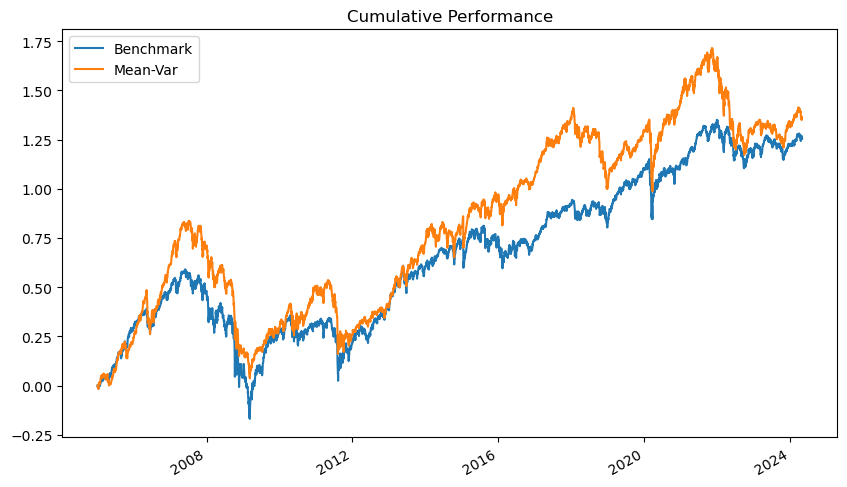

In [42]:
return_series = bs.data.get_return_series()  # Get the underlying asset returns
bm_series = bs.data.bm_series  # Get benchmark returns

fixed_cost = 0.01  # 1%
variable_cost = 0.002  # 0.2%

sim_mv = bt_mv.strategy.simulate(
    return_series=return_series,
    fc=fixed_cost,
    vc=variable_cost
)

sim = pd.concat({
    'Benchmark': bm_series,
    'Mean-Var': sim_mv
}, axis=1).dropna()
sim.columns = ['Benchmark', 'Mean-Var']

# Plot the cumulative performance
np.log((1 + sim)).cumsum().plot(title='Cumulative Performance', figsize = (10, 6))

In [43]:
mv_weights_df = bt_mv.strategy.get_weights_df()

def compute_turnover(weights_df):
    turnover = []
    prev = None
    for date, w in weights_df.iterrows():
        if prev is not None:
            t = np.abs(w - prev).sum()
            turnover.append(t)
        prev = w
    return np.mean(turnover) if turnover else np.nan

mv_turnover = compute_turnover(mv_weights_df)
print(f"Mean-Variance Strategy Average Turnover: {mv_turnover:.4f}")


Mean-Variance Strategy Average Turnover: 0.4529


remove duplicates before unstacking

In [44]:
# Ensure unique (date, id) rows
market = data.market_data.reset_index().drop_duplicates(subset=['date', 'id'], keep='last')
market = market.set_index(['date', 'id'])

# Compute forward returns
prices = market['price'].unstack()
returns = prices.pct_change().shift(-1)
fwd_returns = returns.stack().rename('fwd_return')
fwd_returns.index.names = ['date', 'id']

# Remove existing 'fwd_return' column if present
features = features.drop(columns='fwd_return', errors='ignore')

# Join the forward returns as target
features = features.join(fwd_returns, how='inner')

# Use wide format for rolling ops
returns_unstacked = returns

# Add rolling volatility
for window in [5, 21]:
    colname = f'vol_{window}d'
    vol = returns_unstacked.rolling(window).std().stack().rename(colname)
    features = features.drop(columns=colname, errors='ignore')
    features = features.join(vol, how='left')

# Add lagged returns
for lag in [1, 5, 21]:
    colname = f'ret_lag_{lag}d'
    lag_ret = returns_unstacked.shift(lag).stack().rename(colname)
    features = features.drop(columns=colname, errors='ignore')
    features = features.join(lag_ret, how='left')

# Add momentum
momentum = returns_unstacked.rolling(21).sum().stack().rename('momentum_21d')
features = features.drop(columns='momentum_21d', errors='ignore')
features = features.join(momentum, how='left')








/var/folders/66/f34qqmt15nq__w_74qnrd2vc0000gn/T/ipykernel_95047/4176568508.py:7: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change().shift(-1)


In [45]:
# Define X and y
X = features.drop(columns='fwd_return')
y = features['fwd_return']

# Drop infs/NaNs
X = X.replace([np.inf, -np.inf], np.nan)
mask = X.notna().all(axis=1) & y.notna()
X = X[mask]
y = y[mask]

# Time-based train-test split
split_date = pd.Timestamp('2020-01-01')
dates = X.index.get_level_values('date')

X_train = X[dates < split_date]
y_train = y.loc[X_train.index]

X_test = X[dates >= split_date]
y_test = y.loc[X_test.index]



Train the XGBoost model on training data

In [46]:
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import numpy as np
import joblib

# --- Feature selection ---
selector = VarianceThreshold(threshold=0.0005)
X_sel = selector.fit_transform(X)
selected_columns = X.columns[selector.get_support()]
X_sel = pd.DataFrame(X_sel, columns=selected_columns, index=X.index)

# --- Standardization ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sel)
X_scaled = pd.DataFrame(X_scaled, columns=selected_columns, index=X.index)

# --- Train-test split ---
split_date = pd.Timestamp('2018-01-01')
dates = X_scaled.index.get_level_values('date')
train_idx = dates < split_date
test_idx = dates >= split_date

X_train = X_scaled[train_idx]
y_train = y[train_idx]
X_test = X_scaled[test_idx]
y_test = y[test_idx]

# --- Clip targets ---
y_train_clip = y_train.clip(lower=y_train.quantile(0.01), upper=y_train.quantile(0.99))

# --- Hyperparameter tuning ---
param_dist = {
    'n_estimators': [300, 400, 500],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.02, 0.05],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0.0, 0.1],
    'reg_lambda': [1.0, 5.0],
    'min_child_weight': [1, 5, 10],
    'gamma': [0, 0.1],
    'booster': ['gbtree', 'dart'],
}


tscv = TimeSeriesSplit(n_splits=4)
search = RandomizedSearchCV(
    xgb.XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1,
        tree_method='hist',
        early_stopping_rounds=10,
        eval_metric='rmse',
        verbosity=0,
    ),
    param_distributions=param_dist,
    n_iter=15,
    cv=tscv,
    scoring='r2',
    verbose=1,
)

search.fit(X_train, y_train_clip, eval_set=[(X_test, y_test)])

# --- Evaluation ---
best_model = search.best_estimator_


y_pred = best_model.predict(X_test)
y_pred = np.clip(y_pred, -0.05, 0.05)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Best params: {search.best_params_}")
print(f"Test MSE: {mse:.6f}")
print(f"Test R^2: {r2:.4f}")

# --- Save model and transformers ---
joblib.dump(best_model, 'xgb_model_posr2.joblib')
joblib.dump(scaler, 'scaler_posr2.joblib')
joblib.dump(selector, 'selector_posr2.joblib')


Fitting 4 folds for each of 15 candidates, totalling 60 fits
[0]	validation_0-rmse:0.01892
[1]	validation_0-rmse:0.01892
[2]	validation_0-rmse:0.01892
[3]	validation_0-rmse:0.01892
[4]	validation_0-rmse:0.01892
[5]	validation_0-rmse:0.01892
[6]	validation_0-rmse:0.01892
[7]	validation_0-rmse:0.01892
[8]	validation_0-rmse:0.01892
[9]	validation_0-rmse:0.01892
[0]	validation_0-rmse:0.01895
[1]	validation_0-rmse:0.01895
[2]	validation_0-rmse:0.01895
[3]	validation_0-rmse:0.01895
[4]	validation_0-rmse:0.01895
[5]	validation_0-rmse:0.01895
[6]	validation_0-rmse:0.01895
[7]	validation_0-rmse:0.01895
[8]	validation_0-rmse:0.01895
[9]	validation_0-rmse:0.01895
[10]	validation_0-rmse:0.01895
[0]	validation_0-rmse:0.01900
[1]	validation_0-rmse:0.01900
[2]	validation_0-rmse:0.01900
[3]	validation_0-rmse:0.01900
[4]	validation_0-rmse:0.01900
[5]	validation_0-rmse:0.01900
[6]	validation_0-rmse:0.01900
[7]	validation_0-rmse:0.01900
[8]	validation_0-rmse:0.01900
[9]	validation_0-rmse:0.01900
[0]	vali

['selector_posr2.joblib']

In [47]:
# Reconstruct ML predictions DataFrame using X_test index
ml_preds = X_test.copy()
ml_preds['predicted_return'] = y_pred  # Same index, no mismatch

# (Optional: clip extreme predictions)
ml_preds['predicted_return'] = ml_preds['predicted_return'].clip(-0.05, 0.05)


# Check index is MultiIndex (date, id)
assert ml_preds.index.names == ['date', 'id'], "Expected MultiIndex (date, id)"

# Build date → Series(id → predicted_return)

ml_predicted_returns_dict = {
    date: group.droplevel('date')['predicted_return']
    for date, group in ml_preds.groupby(level='date')
}




In [48]:
Sigma_dict = {}
ml_weights_dict = {}
prev_weights = None

target_vol = 0.02  # target 2% monthly volatility

for date, mu in ml_predicted_returns_dict.items():
    # Covariance estimation
    window_end = date
    valid_dates = return_series.index[return_series.index <= window_end]
    window_start = valid_dates[-252] if len(valid_dates) >= 252 else valid_dates[0]
    returns_window = return_series.loc[window_start:window_end].dropna(axis=1, how='all')
    Sigma = returns_window.cov()
    Sigma_dict[date] = Sigma

    # Clean inputs
    mu = mu[~mu.index.duplicated(keep='first')]
    Sigma = Sigma.loc[~Sigma.index.duplicated(keep='first'), ~Sigma.columns.duplicated(keep='first')]

    # Match assets
    common_assets = mu.index.intersection(Sigma.index)
    if len(common_assets) == 0:
        continue

    mu_aligned = mu.loc[common_assets].clip(-0.02, 0.02)  # tighter prediction clipping
    Sigma_aligned = Sigma.loc[common_assets, common_assets]

    try:
        inv_Sigma = np.linalg.pinv(Sigma_aligned.values)
    except np.linalg.LinAlgError:
        continue

    # Penalize turnover
    if prev_weights is not None:
        aligned_prev = prev_weights.reindex(common_assets).fillna(0)
        mu_aligned -= 0.05 * (mu_aligned - aligned_prev)

    # Compute weights
    raw_weights = inv_Sigma @ mu_aligned.values
    raw_weights = np.maximum(raw_weights, 0)
    clipped_weights = np.clip(raw_weights, 0, 0.02)

    if clipped_weights.sum() > 0:
        clipped_weights /= clipped_weights.sum()

    weights = clipped_weights.copy()

    # Volatility targeting
    try:
        portfolio_vol = np.sqrt(weights @ Sigma_aligned.values @ weights.T)
        if portfolio_vol > 0:
            scale = min(target_vol / portfolio_vol, 1.5)
            weights *= scale
            weights = np.clip(weights, 0, 0.02)
            if weights.sum() > 0:
                weights /= weights.sum()
    except Exception:
        pass

    ml_weights_dict[date] = pd.Series(weights, index=common_assets)
    prev_weights = ml_weights_dict[date]

ml_weights_df = pd.DataFrame(ml_weights_dict).T


Simulate portfolio

In [49]:
def simulate_portfolio(return_series, weights, fc=0.01, vc=0.002):
    """
    Simulates portfolio returns given predicted weights and return series.
    Applies fixed and variable costs.

    Parameters:
        return_series: DataFrame with asset returns (index: date, columns: asset ID)
        weights: DataFrame with portfolio weights per date (same format)
        fc: fixed cost per annum (e.g. 0.01 = 1%)
        vc: variable cost per rebalancing (e.g. 0.002 = 0.2%)

    Returns:
        Series of net portfolio returns
    """
    returns = []
    prev_weights = None

    for date in weights.index:
        w = weights.loc[date]
        rets = return_series.loc[date] if date in return_series.index else None

        if rets is None or rets.isna().all():
            returns.append(np.nan)
            continue

        w = w.reindex(rets.index).fillna(0)
        rets = rets.fillna(0)

        # Gross return
        port_ret = np.dot(w.values, rets.values)

        threshold = 0.1  # 10% change threshold

        # In your for-date loop
        if prev_weights is not None:
            turnover = np.abs(w - prev_weights).sum()
            if turnover < threshold:
                w = prev_weights.copy()
                # apply returns without rebalancing
                port_ret = np.dot(w.values, rets.values) - fc/12
                returns.append(port_ret)
                continue


        # Fixed cost (monthly)
        port_ret -= fc / 12

        returns.append(port_ret)
        prev_weights = w

    return pd.Series(returns, index=weights.index)


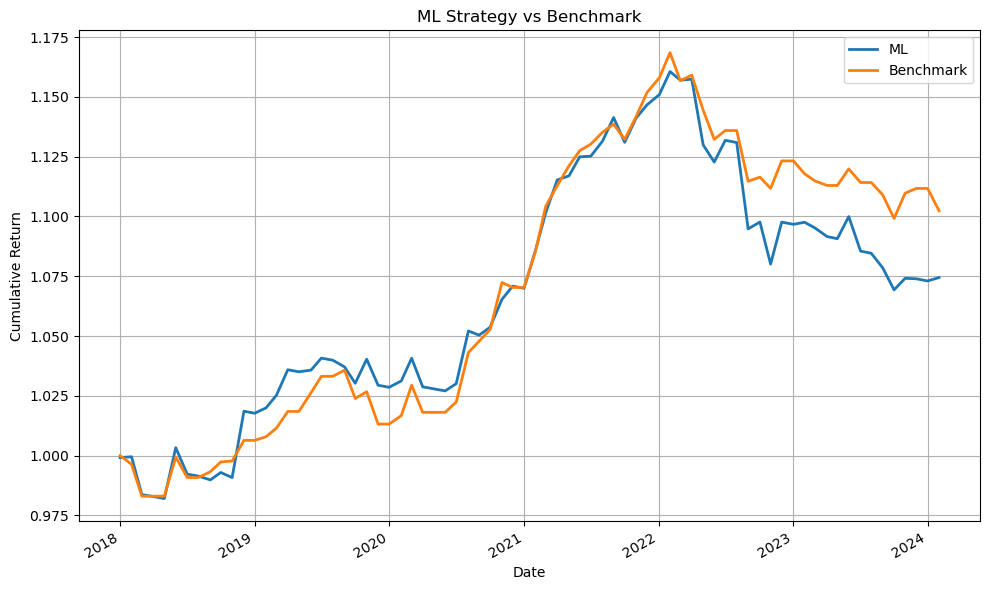

In [50]:
import matplotlib.pyplot as plt
# Step 1: Simulate ML portfolio returns
ml_returns = simulate_portfolio(return_series, ml_weights_df, fc=0.01, vc=0.002)

# Step 2: Ensure index type is datetime
ml_returns.index = pd.to_datetime(ml_returns.index)
bm_series.index = pd.to_datetime(bm_series.index)

# Step 3: Align both series
common_dates = ml_returns.index.intersection(bm_series.index)

# Step 4: Build sim DataFrame
sim = pd.DataFrame({
    'ML': ml_returns.loc[common_dates],
    'Benchmark': bm_series.loc[common_dates]
}).dropna()

# Step 5: Plot cumulative return
cumulative_ml = (1 + sim[['ML', 'Benchmark']]).cumprod()

plt.figure(figsize=(10, 6))
cumulative_ml.plot(ax=plt.gca(), linewidth=2)
plt.title('ML Strategy vs Benchmark')
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.savefig('ml_vs_benchmark.png', dpi=300)
plt.show()




ML Strategy vs Benchmark (Full Period + Last 5 Years)

Implementation of performance metrics

In [51]:
import numpy as np
import pandas as pd

def annualized_return(returns, periods_per_year=12):
    compounded = (1 + returns).prod()
    n_periods = returns.count()
    return compounded ** (periods_per_year / n_periods) - 1

def annualized_volatility(returns, periods_per_year=12):
    return returns.std() * np.sqrt(periods_per_year)

def sharpe_ratio(returns, risk_free_rate=0.0, periods_per_year=12):
    excess = returns - risk_free_rate / periods_per_year
    return annualized_return(excess, periods_per_year) / annualized_volatility(returns, periods_per_year)

def max_drawdown(cumulative_returns):
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min()

def turnover(weights_df):
    """Average L1 norm difference between consecutive weight vectors"""
    return (weights_df.diff().abs().sum(axis=1)).mean()


In [52]:
# --- Compute aligned ML and benchmark returns ---
ml_ret = ml_returns.dropna()
bm_ret = bm_series.loc[ml_ret.index].dropna()
ml_ret = ml_ret.loc[bm_ret.index]  # Align dates

# --- Cumulative returns ---
ml_cum = (1 + ml_ret).cumprod()
bm_cum = (1 + bm_ret).cumprod()

# --- Compute performance metrics ---
full_stats = pd.DataFrame({
    'ML Portfolio': {
        'Annualized Return': annualized_return(ml_ret),
        'Annualized Volatility': annualized_volatility(ml_ret),
        'Sharpe Ratio': sharpe_ratio(ml_ret),
        'Max Drawdown': max_drawdown(ml_cum),
        'Turnover': turnover(ml_weights_df),
    },
    'Benchmark': {
        'Annualized Return': annualized_return(bm_ret),
        'Annualized Volatility': annualized_volatility(bm_ret),
        'Sharpe Ratio': sharpe_ratio(bm_ret),
        'Max Drawdown': max_drawdown(bm_cum),
        'Turnover': np.nan,
    }
})

# --- Display ---
print("\nFull-Period Performance:")
print(full_stats.round(4))



Full-Period Performance:
                       ML Portfolio  Benchmark
Annualized Return            0.0117     0.0159
Annualized Volatility        0.0326     0.0266
Sharpe Ratio                 0.3588     0.5987
Max Drawdown                -0.0787    -0.0593
Turnover                     0.3661        NaN


Subperiod Example (Last 5 years)

In [53]:
cutoff = ml_ret.index >= pd.Timestamp('2019-01-01')
ml_sub = ml_ret.loc[cutoff]
bm_sub = bm_ret.loc[cutoff]

ml_sub_cum = (1 + ml_sub).cumprod()
bm_sub_cum = (1 + bm_sub).cumprod()

weights_sub = ml_weights_df.loc[ml_weights_df.index.intersection(ml_sub.index)]

sub_stats = pd.DataFrame({
    'ML Portfolio': {
        'Annualized Return': annualized_return(ml_sub),
        'Annualized Volatility': annualized_volatility(ml_sub),
        'Sharpe Ratio': sharpe_ratio(ml_sub),
        'Max Drawdown': max_drawdown(ml_sub_cum),
        'Turnover': turnover(weights_sub)
    },
    'Benchmark': {
        'Annualized Return': annualized_return(bm_sub),
        'Annualized Volatility': annualized_volatility(bm_sub),
        'Sharpe Ratio': sharpe_ratio(bm_sub),
        'Max Drawdown': max_drawdown(bm_sub_cum),
        'Turnover': np.nan
    }
})


print("\nLast 5 Years Performance:")
print(sub_stats.round(4))




Last 5 Years Performance:
                       ML Portfolio  Benchmark
Annualized Return            0.0104     0.0178
Annualized Volatility        0.0309     0.0268
Sharpe Ratio                 0.3360     0.6629
Max Drawdown                -0.0787    -0.0593
Turnover                     0.3740        NaN


Full Comparative Table: Classic vs ML vs Benchmark

In [56]:
classic_returns = bt_mv.strategy.simulate(
    return_series=bs.data.get_return_series(),
    fc=0.01,
    vc=0.002
)

sim = sim.rename(columns={
    'Mean-Var': 'Classic',  # rename if your classic strategy was labeled 'Mean-Var'
    'ML Returns': 'ML',     # adjust if your ML returns had a different column name
})



/Users/elenetsaouse/Downloads/qpmwp-course-main 2/src/backtesting/strategy.py:195: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  portf_ret[0] -= varcost[0]
/Users/elenetsaouse/Downloads/qpmwp-course-main 2/src/backtesting/strategy.py:195: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  portf_ret[0] -= varcost[0]


In [63]:
# Align dates
common_dates = classic_returns.index.intersection(ml_returns.index).intersection(bm_series.index)

sim = pd.DataFrame({
    'Classic': classic_returns.loc[common_dates],
    'ML': ml_returns.loc[common_dates],
    'Benchmark': bm_series.loc[common_dates]
}).dropna()

def annual_return(returns, periods_per_year=12):
    compounded = (1 + returns).prod()
    n_periods = returns.count()
    return compounded ** (periods_per_year / n_periods) - 1

def cumulative_return(returns):
    return (1 + returns).prod() - 1

def annual_volatility(returns, periods_per_year=12):
    return returns.std() * np.sqrt(periods_per_year)

def sharpe_ratio(returns, risk_free_rate=0.0, periods_per_year=12):
    excess = returns - risk_free_rate / periods_per_year
    return annual_return(excess, periods_per_year) / annual_volatility(returns, periods_per_year)

def max_drawdown(cumulative_returns):
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min()

def tracking_err(strategy_returns, benchmark_returns, periods_per_year=12):
    return (strategy_returns - benchmark_returns).std() * np.sqrt(periods_per_year)

annual_return_ = {}
cumulative_returns = {}
annual_volatility_ = {}
sharpe_ratio_ = {}
max_drawdown_ = {}
tracking_error_ = {}

for column in ['Classic', 'ML', 'Benchmark']:
    r = sim[column].dropna()
    cr = (1 + r).cumprod()

    annual_return_[column] = annual_return(r)
    cumulative_returns[column] = cumulative_return(r)
    annual_volatility_[column] = annual_volatility(r)
    sharpe_ratio_[column] = sharpe_ratio(r)
    max_drawdown_[column] = max_drawdown(cr)
    if column != 'Benchmark':
        tracking_error_[column] = tracking_err(r, sim['Benchmark'].loc[r.index])

results = pd.concat([
    pd.DataFrame(annual_return_, index=['Annual Return']),
    pd.DataFrame(cumulative_returns, index=['Cumulative Return']),
    pd.DataFrame(annual_volatility_, index=['Annual Volatility']),
    pd.DataFrame(sharpe_ratio_, index=['Sharpe Ratio']),
    pd.DataFrame(max_drawdown_, index=['Max Drawdown']),
    pd.DataFrame(tracking_error_, index=['Tracking Error']),
])

print(results.round(4))


                   Classic      ML  Benchmark
Annual Return       0.0115  0.0117     0.0159
Cumulative Return   0.0729  0.0744     0.1024
Annual Volatility   0.0292  0.0326     0.0266
Sharpe Ratio        0.3926  0.3588     0.5987
Max Drawdown       -0.0710 -0.0787    -0.0593
Tracking Error      0.0136  0.0169        NaN


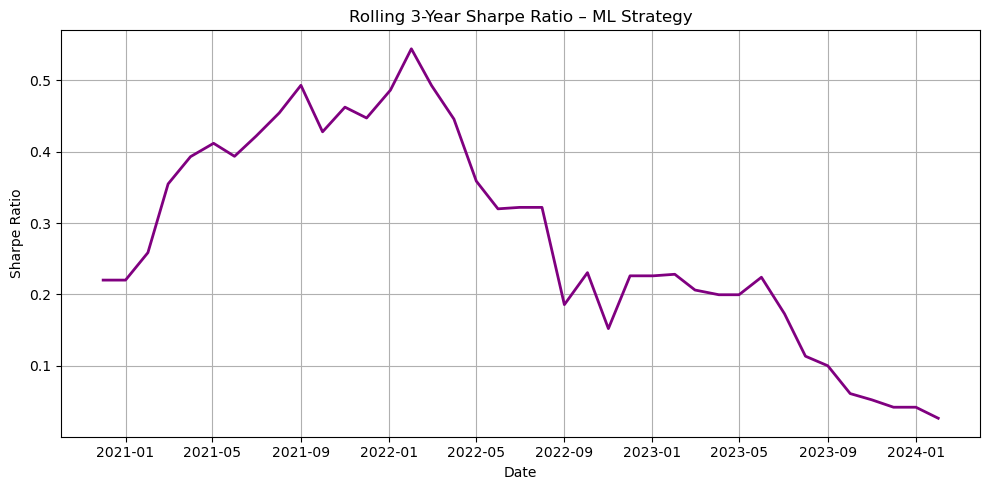

In [32]:
import matplotlib.pyplot as plt

# --- Rolling Sharpe Ratio over 3 years (36 months) ---
monthly_rf = 0.0
window = 36

rolling_sharpe = sim['ML'].rolling(window).apply(
    lambda x: (x.mean() - monthly_rf) / x.std() if x.std() != 0 else 0
)

# --- Plot ---
plt.figure(figsize=(10, 5))
plt.plot(rolling_sharpe.index, rolling_sharpe, color='purple', linewidth=2)
plt.title('Rolling 3-Year Sharpe Ratio – ML Strategy')
plt.ylabel('Sharpe Ratio')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.savefig('rolling_sharpe_ml.png', dpi=300)
plt.show()
